# Data processing

 Reading the dataset

In [117]:
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv('Life Expectancy Data.csv')
print(df.head())

       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.

Preprocessing the data



=== Basic information of the dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 no

<Axes: >

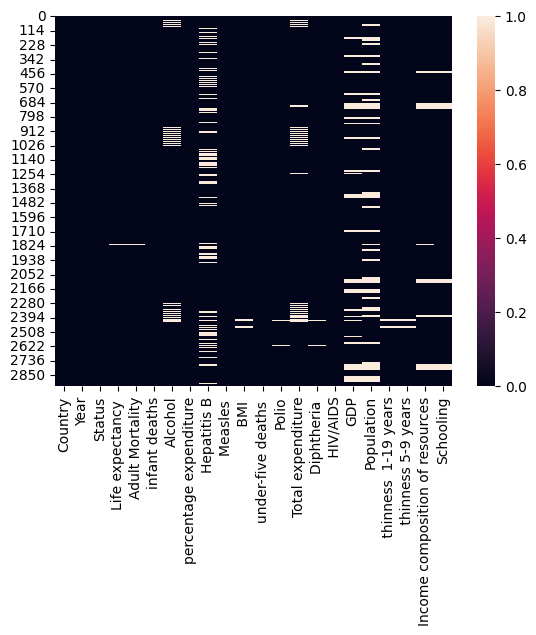

In [118]:
print("\n=== Basic information of the dataset ===")
print(df.info())
print("\n=== Checking for missing values ===")
sns.heatmap(pd.isnull(df))


There are two "types" of null values in the dataset. The dataset restricted to a 
specific country is a time series dataset. The first type of null values is 
when the country does not have data in one variable for a specific year. 
The second type of null values is when the country does not have data 
for a variable across all years.

The first type of null values can be handled by filling them by interpolation. The second type is statistically more complex to
handle, as it requires a more sophisticated approach to impute the missing values,
therefore we will drop the countries of the second type of null values.

Handle missing values according to the previous explanation.


Remaining NAs: 0
Number of lost observations: 810
Share of lost observations: 27.57 %


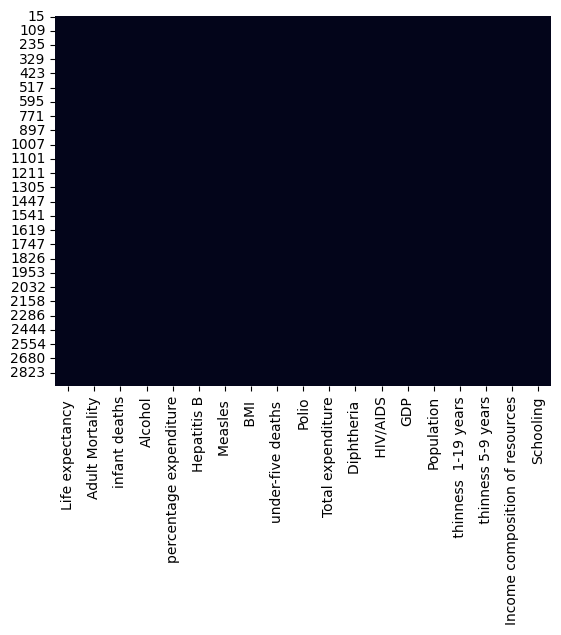

In [119]:
# DROP “TYPE 2” 
id_cols      = ['Country', 'Year']          
cat_cols     = ['Status']                  
num_cols     = [c for c in df.columns if c not in id_cols + cat_cols]

# flag countries where a numeric column is entirely NA
type2_mask   = (df.groupby('Country')[num_cols]
                  .apply(lambda g: g.isna().all())
                  .any(axis=1))

countries_to_drop = type2_mask[type2_mask].index
df_clean = df[~df['Country'].isin(countries_to_drop)].copy()

# IMPUTE “TYPE 1” 
df_clean.sort_values(['Country', 'Year'], inplace=True)

df_clean[num_cols] = (
    df_clean
      .groupby('Country')[num_cols]                    
      .apply(lambda g: (g.interpolate(method='linear', limit_direction='both')
                          .ffill()
                          .bfill()))
      .reset_index(level=0, drop=True)                 
)

for c in cat_cols:
    df_clean[c] = (df_clean.groupby('Country')[c]
                           .ffill()
                           .bfill())

print('Remaining NAs:', df_clean.isna().sum().sum())
sns.heatmap(df_clean[num_cols].isna(), cbar=False)

print('Number of lost observations:', df.shape[0] - df_clean.shape[0])
print('Share of lost observations:', round((df.shape[0] - df_clean.shape[0]) / df.shape[0]*100, 2), '%')


See correlation matrix

<Axes: >

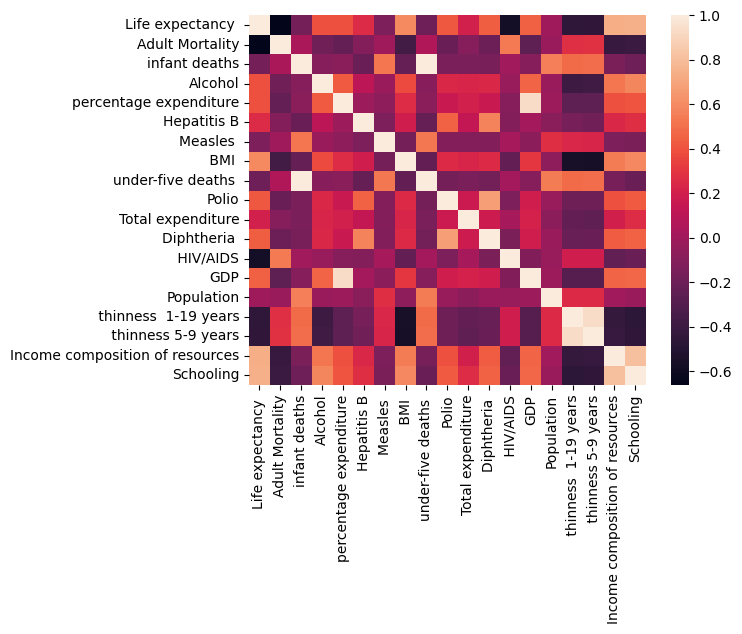

In [120]:
sns.heatmap(df_clean.loc[:, ~df_clean.columns.isin(["Country", "Year", "Status"])].corr())


We will drop the columns: 'Total expenditure', 'Adult Mortality' and 'infant deaths'. 
* 'Total expenditure' is 'percentage expenditure' * 'GDP'.
* 'Adult Mortality' is pretty much the negative of 'Life expectancy'
* 'infant deaths' is highly correlated with 'under five deaths'. If we don't do this, we might have multicollinearity issues.

In [121]:
df_clean.drop(columns=['Total expenditure', 'Adult Mortality', 'infant deaths'], inplace=True)

Final variable transformation

In [128]:
df_clean.drop(columns=['is_developed'], inplace=True) # Doesn't change across time

# Take ln of GDP
df_clean['GDP'] = df_clean['GDP'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Statistical Analysis

### Statistical Overview of the Country-Fixed-Effects Model

#### 1. Specification
$\underbrace{\,y_{it}\,}_{\text{Life expectancy}}
\;=\;
\underbrace{X_{it}\beta}_{\substack{\text{time-varying}\\\text{covariates}}}
+\;
\underbrace{\alpha_i}_{\text{country intercept}}
+\;
u_{it},
\quad
i=1,\dots,N,\; t=1,\dots,T.$

* **Outcome** $y_{it}$: life expectancy for country $i$ in year $t$  
* **Regressors** $X_{it}$: 15 health-, income-, and demographic variables that vary over time  
* **Fixed effect** $\alpha_i$: captures all time-invariant country traits (geography, culture, institutions)  
* **Error** $u_{it}$: idiosyncratic country-year shock  

Because $\alpha_i$ may correlate with $X_{it}$, pooled OLS would be biased. The **within (fixed-effects) transformation** subtracts each country’s mean, eliminating $\alpha_i$.

---

#### 2. Estimator
$\hat\beta_{\text{FE}}=
\Bigl(\sum_{i=1}^{N}\sum_{t=1}^{T}\ddot X_{it}'\ddot X_{it}\Bigr)^{-1}
\Bigl(\sum_{i=1}^{N}\sum_{t=1}^{T}\ddot X_{it}'\ddot y_{it}\Bigr)$
where $\ddot Z_{it}=Z_{it}-\bar Z_i$.

`PanelOLS` computes this estimator and clusters standard errors by **country**, allowing arbitrary serial correlation and heteroskedasticity within each panel.

---

#### 3. Key Fit Statistics

| Quantity | Interpretation |
|----------|----------------|
| **Within \(R^2 = 0.455\)** | Covariates explain 45 % of *within-country* variation in life expectancy. |
| **F-statistic (robust) = 12.5, p < 0.001** | Slopes are jointly significant with clustered SEs. |
| **Poolability test, p < 0.001** | Country dummies are indispensable; a pooled model is misspecified. |

---

#### 4. Coefficient Interpretation
Coefficients measure the **average change in life expectancy within a country** when a regressor moves by one unit, holding other variables constant.  
Example: a HIV/AIDS coefficient of −0.402 implies that a one-unit rise in the HIV index cuts life expectancy by ~0.4 years inside the same country.

---

#### 5. Assumptions
1. **Strict exogeneity**: $E[u_{it}\mid X_{i1},\dots,X_{iT},\alpha_i]=0$.  
2. **No perfect multicollinearity** within panels (absorbed variables are dropped automatically).  
3. **Large $N$, fixed $T$** asymptotics justify clustered inference.

Violations such as reverse causality (e.g., GDP ↔ health) would require instruments or other methods.

---


In [ ]:
from linearmodels.panel import PanelOLS

panel = (
    df_clean
    .set_index(['Country', 'Year'])   # <- entity = Country, time = Year
    .sort_index()
)

y_col = 'Life expectancy '            
y = panel[y_col]

X_cols = [c for c in panel.columns if c != y_col]  
X = panel[X_cols]

fe_mod = PanelOLS(
    y, X,
    entity_effects=True,   # Country fixed effects
)

fe_res = fe_mod.fit(
    cov_type='clustered',
    cluster_entity=True,   # clusters by Country
)

print(fe_res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       Life expectancy    R-squared:                        0.4550
Estimator:                   PanelOLS   R-squared (Between):              0.2620
No. Observations:                2128   R-squared (Within):               0.4550
Date:                Sat, Jul 12 2025   R-squared (Overall):              0.2623
Time:                        17:33:41   Log-likelihood                   -4492.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      110.18
Entities:                         133   P-value                           0.0000
Avg Obs:                       16.000   Distribution:                 F(15,1980)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):             12.497
                            